In [8]:
# import comet_ml in the top of your file
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="XEglZlWHI72CqIq1hcr3RSw7j", project_name="CDCGAN", workspace="kraing")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kraing/cdcgan/3084ba872b9f430badb90ce6c78ddc80



In [9]:
import numpy as np

# Unconditional GAN
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization

# Conditional GAN
from keras.models import Model
from keras.layers import Input, Embedding, Concatenate

Using TensorFlow backend.


In [25]:
def build_discriminator(in_shape=(28,28,1), n_classes=10):
    
    # Label input
    in_label = Input(shape=(1,))
    
    # Embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    
    # Scale uo to image dimensions with linear activation
    n_nodes  = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    
    # Reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    
    # Image input
    in_image = Input(shape=in_shape)
    
    # Concatenate label as channel
    merge = Concatenate()([in_image, li])
    
    # Convolution Layer 1
    fe = Conv2D(128, 3, strides=2, padding='same')(merge)
    fe = BatchNormalization(momentum=0.9)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    
    # Convolution Layer 2
    fe = Conv2D(128, 3, strides=2, padding='same')(fe)
    fe = BatchNormalization(momentum=0.9)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    
    # Flattening features maps + dropout + output layer
    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)
    
    # Define model
    d_model = Model([in_image, in_label], out_layer)
    opt = Adam(lr=0.0002, beta_1=0.5)
    d_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return d_model

In [26]:
def build_generator(latent_dim, n_classes=10):
    
    # Label input
    in_label = Input(shape=(1,))
    
    # Embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    
    # Linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    li = Reshape((7, 7, 1))(li)
    
    # Image generator input
    in_lat = Input(shape=(latent_dim,))
    
    # Foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    
    # Merge image and label input
    merge = Concatenate()([gen, li])
    
    # Upsample 1 - 14x14
    gen = Conv2DTranspose(128, 4, strides=2, padding='same')(merge)
    gen = BatchNormalization(momentum=0.9)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    
    # Upsample 2 -28x28
    gen = Conv2DTranspose(128, 4, strides=2, padding='same')(gen)
    gen = BatchNormalization(momentum=0.9)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    
    # Output layer
    out_layer = Conv2D(1, 7, activation='tanh', padding='same')(gen)
    
    # Define model
    g_model = Model([in_lat, in_label], out_layer)
    return g_model

In [12]:
def build_GAN(g_model, d_model):
    
    # Make weights in the discriminator not trainable
    d_model.trainable = False
    
    # Get noise and label inputs from generator
    gen_noise, gen_label = g_model.input
    
    #Get image output from the generator
    gen_output = g_model.output
    
    # Connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    
    # Define model
    gan_model = Model([gen_noise, gen_label], gan_output)
    
    # Compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    gan_model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return gan_model

In [13]:
def load_real_samples():
    
    # Load dataset
    (trainX, trainy), (_, _) = load_data()
    
    # Exapnd to 3D adding one channel
    X = np.expand_dims(trainX, axis=-1)
    
    # Convert from int to float and rescale from [0, 255] to [-1, 1]
    X = X.astype('float32')
    X = (X - (255 / 2)) / (255 / 2)
    return [X, trainy]


def gen_real_samples(dataset, n_samples):
    
    # split into images and labels
    images, labels = dataset
    
    # choose random instances
    ix = np.random.randint(0, images.shape[0], n_samples)
    X, labels = images[ix], labels[ix]
    
    # generate class labels
    y = np.ones((n_samples, 1))
    return [X, labels], y

In [14]:
def gen_latent_points(latent_dim, n_samples, n_classes=10):
    
    # generate points
    x_input = np.random.randn(latent_dim * n_samples)
    
    # reshape into batch of input for network
    z_input = x_input.reshape(n_samples, latent_dim)
    
    # generate labels
    labels = np.random.randint(0, n_classes, n_samples)
    
    return [z_input, labels]


def gen_fake_samples(generator, latent_dim, n_samples):
    
    #generate latent space points
    z_input, labels_input = gen_latent_points(latent_dim, n_samples)
    
    # predict outputs
    images = generator.predict([z_input, labels_input])
    
    # create class labels
    y = np.zeros((n_samples, 1))
    
    return [images, labels_input], y


In [15]:
def train_gan(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch):
    
    bat_per_epoch  = int(dataset[0].shape[0] / n_batch)
    half_batch = int(bat_per_epoch / 2)
    
    gen_mean = []
    dis_mean = []
    
    # Loop over epochs
    for i in range(n_epochs):
        gen_val = []
        dis_val = []
        # Loop over batches
        for j in range(bat_per_epoch):
            
            # Get random selected 'real' samples
            [X_real, labels_real], y_real = gen_real_samples(dataset, half_batch)
            
            # Update Discriminator weights on real data
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
            # Generate fake samples
            [X_fake, labels_fake], y_fake = gen_fake_samples(g_model, latent_dim, half_batch)
            
            # Update Discriminator weights on generated data
            d_loss2, _ = d_model.train_on_batch([X_fake, labels_fake], y_fake)
            
            # Prepare points in latent space
            [z_input, labels_input] = gen_latent_points(latent_dim, n_batch)
            
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            
            # Update the generator via discriminator error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            
            gen_val.append(g_loss)
            dis_val.append(d_loss2)
        
        gen_mean.append(np.mean(gen_val))
        dis_mean.append(np.mean(dis_val))
        
        print('Epoch-%2d: d_loss = %.3f   g_loss = %.3f' % (i, dis_mean[i], gen_mean[i]))
        
            

In [28]:
latent_dim = 100

d_model = build_discriminator()

g_model = build_generator(latent_dim)

gan_model = build_GAN(g_model, d_model)

dataset = load_real_samples()


In [30]:
train_gan(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128)

Epoch- 0: d_loss = 0.471   g_loss = 1.769
Epoch- 1: d_loss = 0.500   g_loss = 1.841
Epoch- 2: d_loss = 0.509   g_loss = 1.761
Epoch- 3: d_loss = 0.536   g_loss = 1.797
Epoch- 4: d_loss = 0.537   g_loss = 1.783
Epoch- 5: d_loss = 0.549   g_loss = 1.695
Epoch- 6: d_loss = 0.564   g_loss = 1.659
Epoch- 7: d_loss = 0.568   g_loss = 1.630
Epoch- 8: d_loss = 0.579   g_loss = 1.613
Epoch- 9: d_loss = 0.577   g_loss = 1.554
Epoch-10: d_loss = 0.591   g_loss = 1.528
Epoch-11: d_loss = 0.598   g_loss = 1.491
Epoch-12: d_loss = 0.597   g_loss = 1.483
Epoch-13: d_loss = 0.602   g_loss = 1.441
Epoch-14: d_loss = 0.614   g_loss = 1.432
Epoch-15: d_loss = 0.611   g_loss = 1.406
Epoch-16: d_loss = 0.612   g_loss = 1.403
Epoch-17: d_loss = 0.613   g_loss = 1.367
Epoch-18: d_loss = 0.619   g_loss = 1.361
Epoch-19: d_loss = 0.612   g_loss = 1.346


10


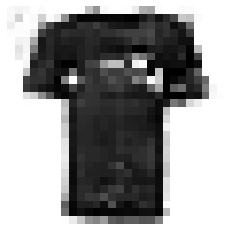

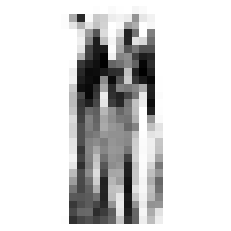

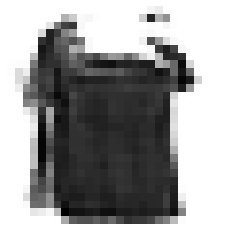

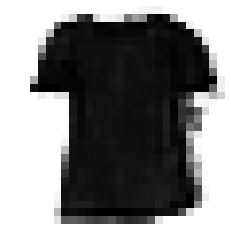

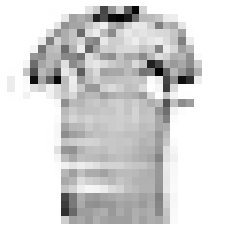

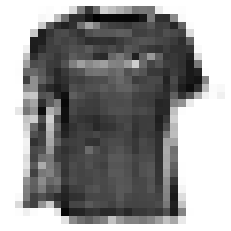

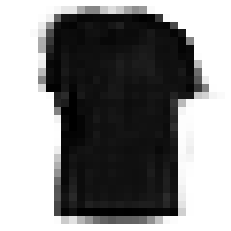

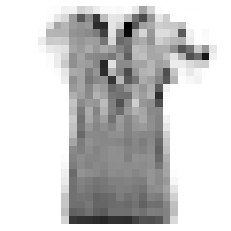

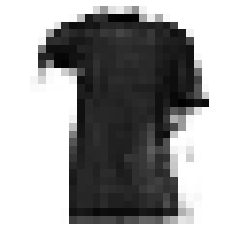

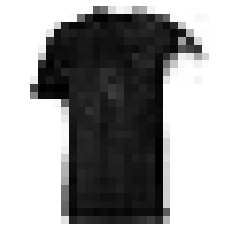

In [33]:
import matplotlib.pyplot as plt

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):

    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    
    # generate labels
    labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n):
    
    # plot images
    for i in range(n):
        # turn off axis
        plt.axis('off')
        
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
        plt.show()
    return

# generate images
latent_points, labels = gen_latent_points(100, 10)

# specify labels
labels = np.asarray([x for _ in range(10) for x in range(10)])

#custom_label = np.asarray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
custom_label = []
for i in range(10):
    custom_label.append(0)

custom_label = np.asarray(custom_label)

# generate images
X  = g_model.predict([latent_points, custom_label])

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

print(len(X))
# plot the result
save_plot(X, custom_label.shape[0])


In [19]:

# at the end of your training, end the Comet experiment
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/kraing/cdcgan/3084ba872b9f430badb90ce6c78ddc80
COMET INFO:   Uploads:
COMET INFO:     code                     : 1 (13 KB)
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO: ---------------------------
COMET INFO: Uploading stats to Comet before program termination (may take several seconds)
